## Data Preparation

In [38]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [39]:
def reshape_pairwise_metric(
    pairs_file,
    metric_file,
    out_file,
):
    with open(pairs_file, 'rb') as f:
        pairs = pickle.load(f)
        
    p0s, p0_counts = np.unique([p[0] for p in pairs], return_counts=True)
    p1s, p1_counts = np.unique([p[1] for p in pairs], return_counts=True)
    
    val_df = pd.read_csv(metric_file)
    
    metric_df = pd.DataFrame(val_df.values.reshape((len(p0s), len(p1s))), columns=p1s, index=p0s)
    metric_df.to_csv(out_file)
    
def reshape_pairwise_metric2(
    pairs_file,
    metric_file,
    out_file,
):
    with open(pairs_file, 'rb') as f:
        pairs = pickle.load(f)
        
    p0s = np.unique([p[0] for p in pairs])
    p1s = pairs[0][1]
    
    metric_df = pd.read_csv(metric_file, header=None)

    metric_df.index = p0s
    metric_df.columns = p1s
    metric_df.to_csv(out_file)

In [40]:
metric_input_dir = Path('2_outputs/pairwise/')
pairs_dir = Path("./tmp/s3_files/")
out_dir = Path('./3_outputs/pairwise_processed')
out_dir.mkdir(exist_ok=True, parents=True)

for suffix in ('_disease', '_pathway'):
    metric_files = list(metric_input_dir.glob(f'*{suffix}.csv'))
    
    for metric_file in tqdm(metric_files):
        if metric_file.name.startswith("personalized_pagerank"):
            fun = reshape_pairwise_metric2
            pairs_file = pairs_dir / f'input_pairs_obl{suffix}.pkl'
        else:
            fun = reshape_pairwise_metric
            pairs_file = pairs_dir / f'pairs_obl{suffix}.pkl'
        out_file = out_dir / metric_file.name
        fun(
            pairs_file=pairs_file,
            metric_file=metric_file,
            out_file=out_file,
        )

100%|██████████| 8/8 [04:59<00:00, 37.43s/it]


## Attach IRR information, Move Metrics to Common Directory

In [41]:
from pathlib import Path
import pandas as pd
from anngel.datasets.openbiolink import OpenBioLinkDataset
from anngel.datalib.s3datastore import S3DataStore

In [42]:
pp_dir = Path('./3_outputs/pairwise_processed/')
out_file_p_fs = Path('./3_outputs/pairwise_metrics_feature_selection.csv')
nd_dir = Path('./2_outputs/nodewise/')
metrics_dir = Path('./3_outputs/metrics/')
metrics_dir.mkdir(exist_ok=True, parents=True)

pp_files_d = list(pp_dir.glob('*_disease.csv'))
pp_files_p = list(pp_dir.glob('*_pathway.csv'))


data_store = S3DataStore(
    aws_access_key_id=None,
    aws_secret_access_key=None,
    aws_session_token=None,
    bucket_name="nnedl-core-prd-eu-central-1-curated",
    prefix="compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/",
    local_directory="tmp/s3_files",
)

ds = OpenBioLinkDataset("./tmp/openbiolink/")

irr_df_obl = pd.read_csv(data_store.get_file("Nodes_OpenBioLink_connected_IR.txt").local_path)
irr_df = pd.read_csv(data_store.get_file("full_node_info_train_val_test.csv").local_path, sep=";")
irr_df["irr2"] = irr_df["IR list"] == "IR_True"
irr_df = (
    ds.get_nodes()
    .merge(irr_df[["Node ID", "irr2"]], how="left", left_on="node_id", right_on="Node ID")
    .drop(columns=["Node ID"])
)
irr_df["irr2"].fillna(False, inplace=True)
irr_df["irr"] = irr_df['node_id'].isin(irr_df_obl['node_id'])

def attach_irr(metric_df, col_names=['irr', 'irr2']):
    metric_df = metric_df.join(irr_df[col_names], how='left')
    n_col = metric_df.shape[1]
    return metric_df

def select_gene(metric_df):
    idx = irr_df[irr_df['node_id'].str.startswith('NCBIGENE:')].index
    return metric_df[metric_df.index.isin(idx)]

index=None
for f in [*pp_files_d, *pp_files_p]:
    nm = f.name.split('.')[0]
    m_df = pd.read_csv(f, index_col=0)
    m_df = attach_irr(m_df)
    m_df = select_gene(m_df)
    m_df.to_csv(metrics_dir / f'{nm}.csv')
    

nd_files = list(nd_dir.glob('*.csv'))
for f in nd_files:
    nm = f.name.split('.')[0]
    m_df = attach_irr(pd.read_csv(f))
    m_df = select_gene(m_df)
    m_df.to_csv(metrics_dir / f'{nm}.csv')

Found 18 files in local directory "tmp/s3_files".


ClientError: An error occurred (ExpiredToken) when calling the ListObjects operation: The provided token has expired.

## Machine Learning

In [ ]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

metrics_dir = Path('./3_outputs/metrics/')
metrics_files = list(metrics_dir.glob('*.csv'))

In [ ]:
metrics_file = metrics_files[0]

sampling_strategy = 1.0
m_df = pd.read_csv(metrics_file, index_col=0)
y = m_df['irr'].values
idcs = np.arange(len(y))

idcs_train, idcs_val = train_test_split(idcs, stratify=y, test_size=0.25)

sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
idcs_train_rs, y_rs = sampler.fit_resample(idcs_train.reshape(-1, 1), y[idcs_train])
idcs_train_rs = idcs_train_rs.flatten()

pd.DataFrame(dict(index_train=idcs_train_rs)).to_csv('3_outputs/indices_train_rs.csv', index=False)
pd.DataFrame(dict(index_train=idcs_train)).to_csv('3_outputs/indices_train.csv', index=False)
pd.DataFrame(dict(index_val=idcs_val)).to_csv('3_outputs/indices_val.csv', index=False)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
def calc_metrics(y_pred, y_true):
    return {
        "f1": f1_score(y_pred=y_pred, y_true=y_true),
        "recall": recall_score(y_pred=y_pred, y_true=y_true),
        "precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
        "confusion_matrix": confusion_matrix(y_pred=y_pred, y_true=y_true),
    }

def custom_scorer_builder(X_val, y_val):
    def custom_scorer(clf, X, y):
        y_val_pred = clf.predict(X_val)
        metrics = calc_metrics(y_pred=y_val_pred, y_true=y_val)
        cm = metrics["confusion_matrix"]
        metrics["TP"] = cm[0, 0]
        metrics["FP"] = cm[0, 1]
        metrics["FN"] = cm[1, 0]
        metrics["TN"] = cm[1, 1]
        del metrics["confusion_matrix"]
        return metrics

    return custom_scorer

def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    metrics = calc_metrics(y_pred=y_pred, y_true=y)
    cm = metrics["confusion_matrix"]
    metrics["TP"] = cm[0, 0]
    metrics["FP"] = cm[0, 1]
    metrics["FN"] = cm[1, 0]
    metrics["TN"] = cm[1, 1]
    del metrics["confusion_matrix"]
    return metrics

def custom_scorer_builder2(X_val, y_val):
    return custom_scorer

def fit_model(
    m_df,
    idcs_train,
    idcs_val,
    x_col_idcs,
    y_col_idx,
    model,
    parameters,
    scoring_builder=custom_scorer_builder,
    refit='f1',
    cv=5,
    **kwargs
):
    n_col=m_df.shape[1]
    X_train = m_df.iloc[idcs_train, x_col_idcs].values
    y_train = m_df.iloc[idcs_train, y_col_idx]
    X_val = m_df.iloc[idcs_val, x_col_idcs].values
    y_val = m_df.iloc[idcs_val, y_col_idx]
    
    scoring = scoring_builder(X_val, y_val)
    
    clf = GridSearchCV(model, parameters, scoring=scoring, refit=refit, cv=cv, **kwargs)
    clf.fit(X=X_train, y=y_train)
    return clf

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tf = tsne.fit_transform(m_df.iloc[:, :-1].values)

In [ ]:
idcs = np.argsort(m_df['irr'])

In [ ]:
m_df['irr'].sum()

In [ ]:
import seaborn as sns
sns.scatterplot(x=X_tf[idcs, 0], y=X_tf[idcs, 1], hue = m_df.iloc[idcs]['irr'], alpha=0.5)

In [ ]:
classifiers_dir = Path('./3_outputs/classifiers/')
classifiers_dir.mkdir(exist_ok=True, parents=True)

def get_x_col_idcs(m_df):
    return np.where(~m_df.columns.isin(['irr', 'irr2']))[0]

def get_y_col_idx(m_df, col_name='irr'):
    return np.where(m_df.columns == col_name)[0][0]

def train_predictor(metrics_file):
    m_df = pd.read_csv(metrics_file, index_col=0)
    m = RandomForestClassifier()
    parameters = dict(
        n_estimators=[100, 250, 500],
        max_depth=[None, 2, 5, 10],
        min_samples_leaf=[1, 32, 128, 256],
        max_features=['sqrt', 1, 2, 4, 8,]
    )

    x_col_idcs=get_x_col_idcs(m_df)
    y_col_idx=get_y_col_idx(m_df, 'irr')

    clf = fit_model(
        m_df=m_df,
        idcs_train=idcs_train_rs,
        idcs_val=idcs_val,
        x_col_idcs=x_col_idcs,
        y_col_idx=y_col_idx,
        model=m,
        parameters=parameters,
        scoring_builder=custom_scorer_builder2,
        refit='f1',
        cv=5,
        n_jobs=20,
    )

    nm = metrics_file.name.split('.')[0]
    with open(classifiers_dir / f'{nm}.pkl', 'wb') as f:
        pickle.dump(clf, f)
    return clf

In [ ]:
from tqdm import tqdm

for metrics_file in tqdm(metrics_files):
    train_predictor(metrics_file)

In [12]:
import pickle

idcs_train_rs = pd.read_csv('3_outputs/indices_train_rs.csv').iloc[:,0].values
idcs_val = pd.read_csv('3_outputs/indices_val.csv').iloc[:,0].values

probas = {}
val_results = {}
index = None

for metrics_file in metrics_files:
    nm = metrics_file.name.split('.')[0]

    with open(f'./3_outputs/classifiers/{nm}.pkl', 'rb') as f:
        clf = pickle.load(f)
    
    m_df = pd.read_csv(f'./3_outputs/metrics/{nm}.csv', index_col=0)
    index=m_df.index
    print(m_df.shape)
    
    x_col_idcs=get_x_col_idcs(m_df)
    y_col_idx=get_y_col_idx(m_df, 'irr')
    
    X_val = m_df.iloc[idcs_val,x_col_idcs].values
    y_val = m_df.iloc[idcs_val,y_col_idx].values
    X = m_df.iloc[:,x_col_idcs].values
    y = m_df.iloc[:,y_col_idx].values

    probas[nm] = clf.predict_proba(X)[:, 1]
    
    y_val_pred = clf.predict(X_val)
    val_results[nm] = calc_metrics(y_true=y_val, y_pred=y_val_pred)
    
proba_df = pd.DataFrame(probas, index=index)
proba_df['irr'] = m_df['irr']
proba_df['irr2'] = m_df['irr2']
proba_df.to_csv('3_outputs/probabilities.csv')

(19598, 468)
(19598, 1462)
(19598, 468)
(19598, 1462)
(19598, 1462)
(19598, 468)
(19598, 3)
(19598, 1462)
(19598, 468)
(19598, 3)
(19598, 3)
(19598, 468)
(19598, 1462)
(19598, 1462)
(19598, 3)
(19598, 468)
(19598, 3)
(19598, 3)
(19598, 3)
(19598, 468)
(19598, 3)
(19598, 1462)
(19598, 3)
(19598, 468)
(19598, 1462)


In [1]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

import pandas as pd
import numpy as np

def get_x_col_idcs(m_df):
    return np.where(~m_df.columns.isin(['irr', 'irr2']))[0]

def get_y_col_idx(m_df, col_name='irr'):
    return np.where(m_df.columns == col_name)[0][0]

def calc_metrics(y_pred, y_true):
    return {
        "f1": f1_score(y_pred=y_pred, y_true=y_true),
        "recall": recall_score(y_pred=y_pred, y_true=y_true),
        "precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
        "confusion_matrix": confusion_matrix(y_pred=y_pred, y_true=y_true),
    }


proba_df = pd.read_csv('3_outputs/probabilities.csv', index_col=0)
index=proba_df.index

x_col_idcs=get_x_col_idcs(proba_df)
y_col_idx=get_y_col_idx(proba_df, 'irr')

X = proba_df.iloc[:,x_col_idcs].values
y = proba_df.iloc[:,y_col_idx].values

idcs_train_rs = pd.read_csv('3_outputs/indices_train_rs.csv').iloc[:, 0]
idcs_train = pd.read_csv('3_outputs/indices_train.csv').iloc[:, 0]
idcs_val = pd.read_csv('3_outputs/indices_val.csv').iloc[:, 0]
index_val = index[idcs_val]

X_train_rs = X[idcs_train_rs, :]
y_train_rs = y[idcs_train_rs]
X_val = X[idcs_val, :]
y_val = y[idcs_val]


lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=(1), max_iter=1000, C=0.5)
# lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_rs, y_train_rs)
lr.coef_

/nfs_home/users/thzo/.conda/envs/giannt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([[1.05071119, 0.        , 1.08046135, 1.05122052, 1.03630478,
        0.        , 0.        , 0.98026317, 1.13415285, 0.90853858,
        0.        , 1.0814191 , 0.98091423, 1.03077432, 0.96219587,
        1.12779692, 0.49035091, 0.        , 0.        , 1.12635147,
        0.        , 0.98534424, 0.60248069, 1.1397293 , 1.05075471]])

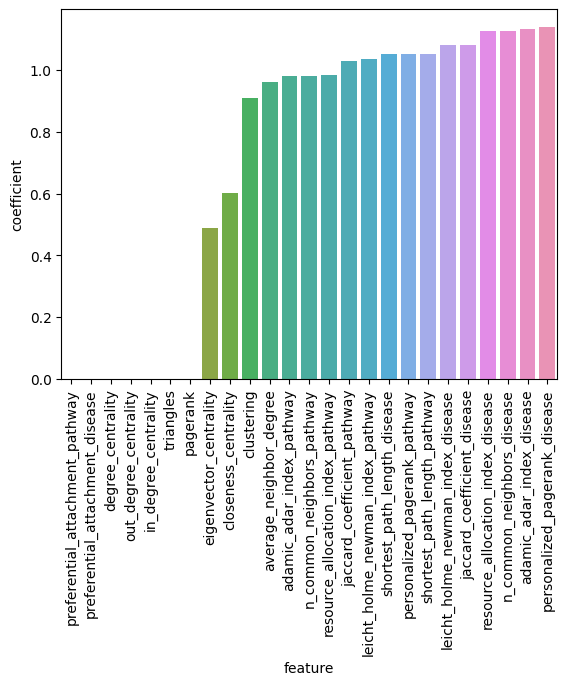

In [2]:
import seaborn as sns
plot_df = pd.DataFrame({'feature': proba_df.columns[x_col_idcs].values, 'coefficient': lr.coef_[0]})
plot_df['coefficient_abs'] = plot_df['coefficient'].abs()

plot = sns.barplot(plot_df.sort_values('coefficient_abs'), x='feature', y='coefficient')
_ = plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=90, )

In [3]:
y_val_pred = lr.predict(X_val)

calc_metrics(y_pred=y_val_pred, y_true=y_val)

{'f1': 0.0,
 'recall': 0.0,
 'precision': 0.0,
 'confusion_matrix': array([[4886,    0],
        [  14,    0]])}

In [4]:
((~proba_df['irr']) & proba_df['irr2']).sum(), proba_df['irr2'].sum()

(418, 420)

In [5]:
test_idcs = (((~proba_df['irr']) & proba_df['irr2']) | ((~proba_df['irr']) & (~proba_df['irr2'])))
test_idcs = np.argwhere(test_idcs.values)[:,0]

x_col_idcs = get_x_col_idcs(proba_df)
y_col_idx = get_y_col_idx(proba_df, col_name='irr2')

X_test = proba_df.iloc[test_idcs,x_col_idcs].values
y_test = proba_df.iloc[test_idcs,y_col_idx].values
test_index = proba_df.index[test_idcs]

In [6]:
y_test_prob = lr.predict_proba(X_test)

In [7]:
tmp_df = pd.DataFrame(y_test_prob, index=test_index)
tmp_df['irr2'] = y_test
tmp_df_sorted = tmp_df.sort_values(0, ascending=True)

In [8]:
tmp_df_sorted

,0,1,irr2
103179,0.998134,0.001866,False
110830,0.998590,0.001410,False
113836,0.999083,0.000917,False
109545,0.999121,0.000879,False
113813,0.999221,0.000779,False
...,...,...,...
107075,0.999866,0.000134,True
107071,0.999866,0.000134,False
107070,0.999866,0.000134,False
107068,0.999866,0.000134,False


In [9]:
n_top = 100

tmp_df_sorted.iloc[:n_top]['irr2'].sum() / n_top

0.05

In [14]:
n_top = 10

tmp_df_sorted.iloc[:n_top]['irr2'].sum() / n_top

0.0

In [10]:
y_prob = lr.predict_proba(X)

In [11]:
y_prob_df = pd.DataFrame(y_prob, index=proba_df.index)
y_prob_df.to_csv('3_outputs/y_prob_stacked.csv')

In [12]:
y_prob_df

,0,1
103175,0.999866,0.000134
103176,0.999863,0.000137
103177,0.999857,0.000143
103178,0.999856,0.000144
103179,0.998134,0.001866
...,...,...
122768,0.999866,0.000134
122769,0.999863,0.000137
122770,0.999864,0.000136
122771,0.999866,0.000134


In [13]:
from anngel.datasets.openbiolink import OpenBioLinkDataset

ds = OpenBioLinkDataset("./tmp/openbiolink/")
nodes_df = ds.get_nodes()

y_prob_df.join(nodes_df, how='left').sort_values(0)

,0,1,node_id,node_type
114276,0.000137,0.999863,NCBIGENE:5167,GENE
112445,0.000137,0.999863,NCBIGENE:4000,GENE
112414,0.000137,0.999863,NCBIGENE:3991,GENE
108685,0.000137,0.999863,NCBIGENE:2353,GENE
106827,0.000137,0.999863,NCBIGENE:1588,GENE
...,...,...,...,...
107400,0.999866,0.000134,NCBIGENE:196500,GENE
107399,0.999866,0.000134,NCBIGENE:1965,GENE
114702,0.999866,0.000134,NCBIGENE:54491,GENE
114704,0.999866,0.000134,NCBIGENE:54494,GENE
